In [1]:
# lets build cifar 10 classifier from scratch

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
])

In [3]:
#lets load our dataset, only converting to tensor, we will be adding transformations later
train_data = datasets.CIFAR10('./data', train=True, download=True, transform= train_transforms)

#pin_memory parameter will be useful for GPUs
train_loader_args = {"batch_size": 128, "shuffle":True, "num_workers":2, "pin_memory":True}
train_loader = DataLoader(train_data, **train_loader_args)

Files already downloaded and verified


In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import lightning as L
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


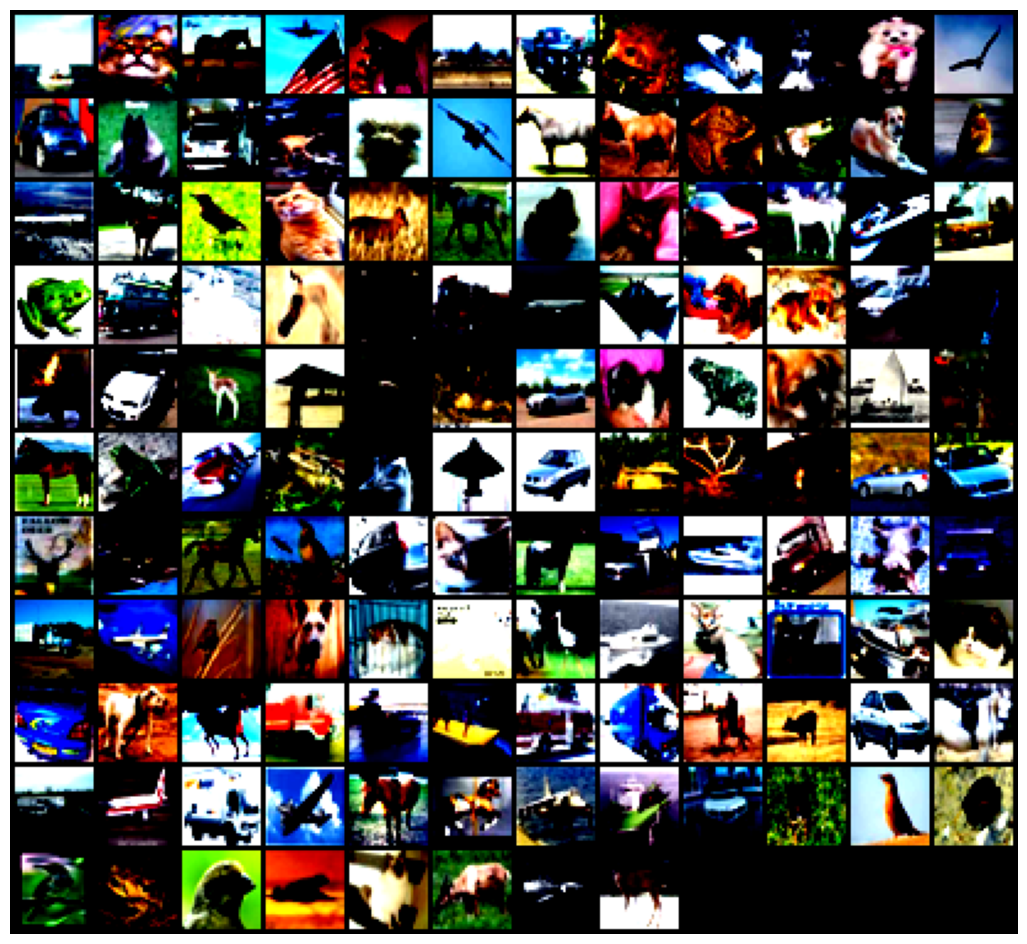

In [5]:
def visualise_dataset(train_loader):
    images, labels = next(iter(train_loader))
    
    combined_image = make_grid(images, nrow=12)
    plt.figure(figsize=(16,12))
    plt.imshow(combined_image.numpy().transpose(1,2,0))
    plt.axis('off')
visualise_dataset(train_loader)

In [6]:
import torch.nn as nn
import torch

In [7]:
test_data = datasets.CIFAR10('./data',download=True, train=False, transform= test_transforms)
test_loader_args = {"batch_size": 128, "shuffle":False, "num_workers":2, "pin_memory":True}
test_loader = DataLoader(test_data, **test_loader_args)

Files already downloaded and verified


In [8]:
def convblock(in_channels, out_channels, kernel, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(0.1)
    )

In [9]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [10]:
class nn_model(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 =  convblock(3,32,3,1,1) #32 output size
        self.conv2 = convblock(32,32,3,1,1) #32 output size
        self.pool1 = nn.MaxPool2d(2) #16

        self.conv3 = convblock(32,64,3,1,1) #16
        self.conv4 = convblock(64,64, 3, 1, 1) #16
        self.pool2  = nn.MaxPool2d(2) #8

        self.conv5 = convblock(64, 128, 3, 1, 1) #8
        self.conv6 = convblock(128 ,128,3,1,1) #8

        self.conv7 = convblock(128,256,3) #6
        self.conv8 = nn.Conv2d(256,256,3) #4
        self.conv9 = nn.AdaptiveAvgPool2d(1) # reduces our output to size 1 
        # we need one fully connected layer here
        self.fc1  = nn.Linear(256,10)
    def forward(self,x):
        x= self.conv1(x)
        x= self.conv2(x)+x
        x= self.pool1(x)
        x= self.conv3(x)
        x= self.conv4(x)+x
        x= self.pool2(x)
        x= self.conv5(x)
        x= x+ self.conv6(x)

        x= self.conv7(x)
        x= self.conv9(self.conv8(x))
        x = x.view(-1, 256) #because we have total 10 classes
        x= self.fc1(x)
        return x
    def training_step(self, batch, batch_idx):
        images, labels = batch
        output= self.forward(images)
        prediction = output.argmax(axis=1)
        loss= F.cross_entropy(output, labels)
        self.log("train_loss", loss, prog_bar=True)
        accuracy = (prediction.eq(labels).sum().item())*100/len(labels)
        self.log("train_accuracy", accuracy, prog_bar=True)
        return loss
    def validation_step(self,batch,batch_idx):
        images, labels = batch
        output= self.forward(images)
        prediction = output.argmax(axis=1)
        loss= F.cross_entropy(output, labels)
        self.log("test_loss", loss, prog_bar=True)
        accuracy = (prediction.eq(labels).sum().item())*100/len(labels)
        self.log("test_accuracy", accuracy, prog_bar=True)
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01)
        return optimizer

In [11]:
model = nn_model()

In [12]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [13]:
trainer = L.Trainer(max_epochs=5, persistent_workers=True) # it reduces the training time

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
#we have added resnet kind of architecture to reduce gradient vanishing
# we have also increased our model size
# we were using very low learning rate, that's why model was taking so much time to increase its accuracy
# lets train for one more epoch
#model is learning , i don't know why its not working in gradio app
#lets train some more

In [15]:
trainer.fit(model, train_loader, test_loader)


   | Name  | Type              | Params
---------------------------------------------
0  | conv1 | Sequential        | 960   
1  | conv2 | Sequential        | 9.3 K 
2  | pool1 | MaxPool2d         | 0     
3  | conv3 | Sequential        | 18.6 K
4  | conv4 | Sequential        | 37.1 K
5  | pool2 | MaxPool2d         | 0     
6  | conv5 | Sequential        | 74.1 K
7  | conv6 | Sequential        | 147 K 
8  | conv7 | Sequential        | 295 K 
9  | conv8 | Conv2d            | 590 K 
10 | conv9 | AdaptiveAvgPool2d | 0     
11 | fc1   | Linear            | 2.6 K 
---------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.705     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 4: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s, v_num=4, train_loss=0.716, train_accuracy=73.80, test_loss=0.866, test_accuracy=70.60]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 391/391 [00:41<00:00,  9.38it/s, v_num=4, train_loss=0.716, train_accuracy=73.80, test_loss=0.866, test_accuracy=70.60]


In [16]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 10696), started 18:18:42 ago. (Use '!kill 10696' to kill it.)

In [56]:
import gradio as gr

In [57]:
train_data.cl

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [19]:
# i got the issue, we are not resizing it
import numpy as np
import gradio as gr

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
from PIL import Image

def resize_image(image):
    img = Image.fromarray(image)
    img = img.resize((32,32))
    return img

def predict(image):
    img = resize_image(image)

    img_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
    ])

    img = img_transforms(img)

    img = img.unsqueeze(0)

    output= model(img)

    # Make prediction
    prediction = output.argmax(axis=1)

    # Assuming train_data.classes is a list of class names
    return train_data.classes[prediction.item()]


In [35]:
interface = gr.Interface(fn=predict, 
                         inputs=[gr.Image()], 
                         outputs=["text"])
interface.launch()

Running on local URL:  http://127.0.0.1:7885

To create a public link, set `share=True` in `launch()`.


In [ ]:
#our model needs to be better trained, currently is has accuracy of about 40-50%, we will try to do it in next session, thanks

In [ ]:
# i hope it gives better result this time